# Urban heat island (UHI) exploratory data analysis (EDA)

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from uhi_cws_lausanne import plot_utils

figwidth, figheight = plt.rcParams["figure.figsize"]
sns.set_style("whitegrid")

In [ ]:
# spatial extent
agglom_extent_filepath = "../data/raw/agglom-extent.gpkg"
stations_gdf_filepath = "../data/processed/stations.gpkg"
ts_df_filepath = "../data/processed/ts-df.csv"

t_label = "T [$^{\circ}$C]"
t_mean_label = "T$_{mean}$ [$^{\circ}$C]"
t_minus_mean_label = "T - T$_{mean}$ [$^{\circ}$C]"
t_std_label = "T$_{std}$ [$^{\circ}$C]"

dst_t_ts_filepath = "../reports/figures/t-ts.pdf"
dst_t_mean_maps_filepath = "../reports/figures/t-mean-maps.png"
dst_t_minus_mean_maps_filepath = "../reports/figures/t-t-mean-maps.png"

# for plots
compare_maps_kwargs = dict(facecolor=(0.87, 0.56, 0.02, 0.2), edgecolor="gray")
savefig_map_kwargs = dict(bbox_inches="tight", dpi=300)

In [ ]:
region = gpd.read_file(agglom_extent_filepath)["geometry"].iloc[:1]

In [ ]:
stations_gdf = gpd.read_file(stations_gdf_filepath)
# get the station id column label
station_id_col = stations_gdf.columns.difference(["geometry", "source"])[0]
# set the station id as index
stations_gdf = stations_gdf.set_index(station_id_col)
# show the data frame
stations_gdf

,source,geometry
station_id,,
NABLAU,Official,POINT (2539020 1152974)
PUY,Official,POINT (2540819 1151510)
WSLLAF,Official,POINT (2539058 1156741)
VD_Lausanne_PdL,Official,POINT (2537375 1154164)
VD_Bussigny,Official,POINT (2532800 1155659)
...,...,...
70:ee:50:84:ac:56,CWS,POINT (2527218.662 1151197.937)
70:ee:50:90:70:e6,CWS,POINT (2544643.669 1150861.784)
70:ee:50:96:f5:ca,CWS,POINT (2530922.028 1154373.025)


In [ ]:
ts_df = pd.read_csv(
    ts_df_filepath, index_col=["heatwave", "time"], parse_dates=["time"]
)
ts_df_dict = {
    source: ts_df[source_ser.index]
    for source, source_ser in stations_gdf.groupby("source", sort=False)
}

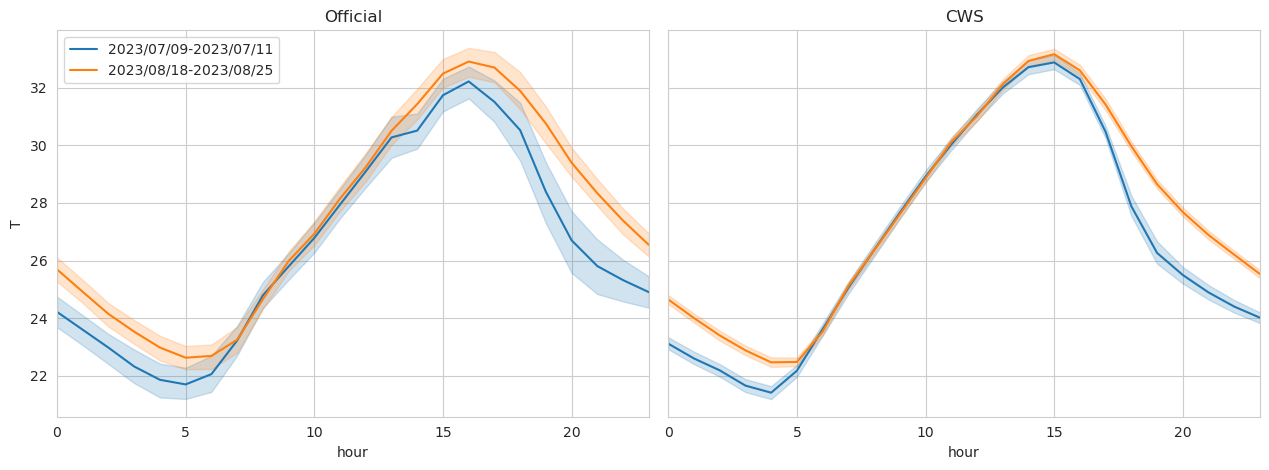

In [ ]:
num_cols = len(ts_df_dict)

fig, axes = plt.subplots(
    1, num_cols, figsize=(num_cols * figwidth, figheight), sharey=True
)
for i, (source, source_ts_df) in enumerate(ts_df_dict.items()):
    plot_utils.hourly_lineplot(
        source_ts_df.rename(columns={source_ts_df.columns[0]: t_label}),
        ax=axes[i],
        legend=i == 0,
    )
    axes[i].set_title(source)
    axes[i].set_xlim([0, 23])
fig.tight_layout()
fig.savefig(dst_t_ts_filepath)

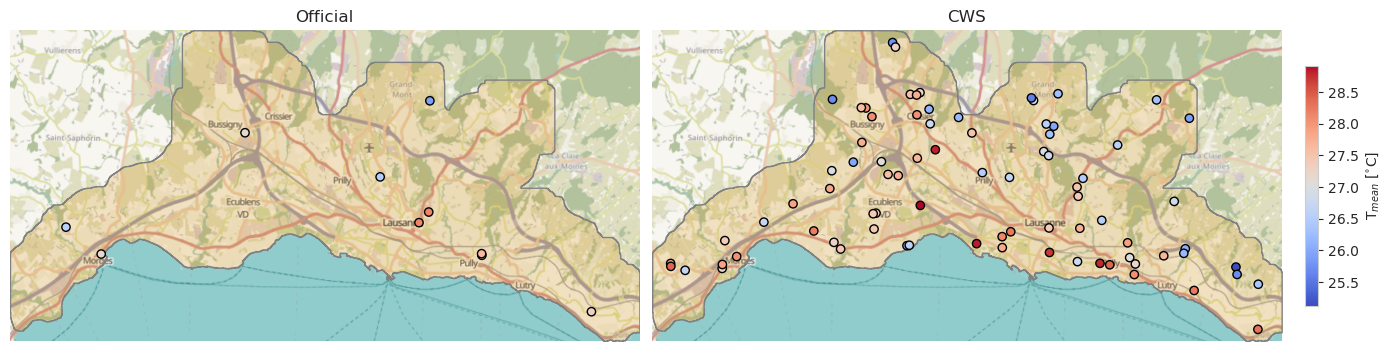

In [ ]:
fig = plot_utils.compare_maps(
    stations_gdf,
    pd.concat(
        [source_ts_df.mean() for _, source_ts_df in ts_df_dict.items()],
        axis="rows",
    ),
    var_label=t_mean_label,
    region_gdf=region,
    **compare_maps_kwargs,
)
fig.savefig(dst_t_mean_maps_filepath, **savefig_map_kwargs)

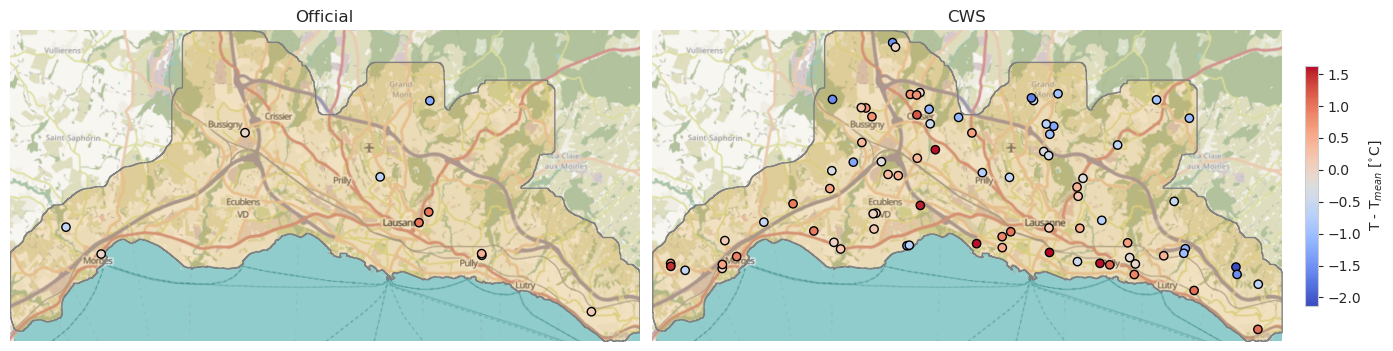

In [ ]:
fig = plot_utils.compare_maps(
    stations_gdf,
    pd.concat(
        [
            source_ts_df.apply(lambda row: row - row.mean(), axis="columns").mean()
            for _, source_ts_df in ts_df_dict.items()
        ],
        axis="rows",
    ),
    var_label=t_minus_mean_label,
    region_gdf=region,
    **compare_maps_kwargs,
)
fig.savefig(dst_t_minus_mean_maps_filepath, **savefig_map_kwargs)

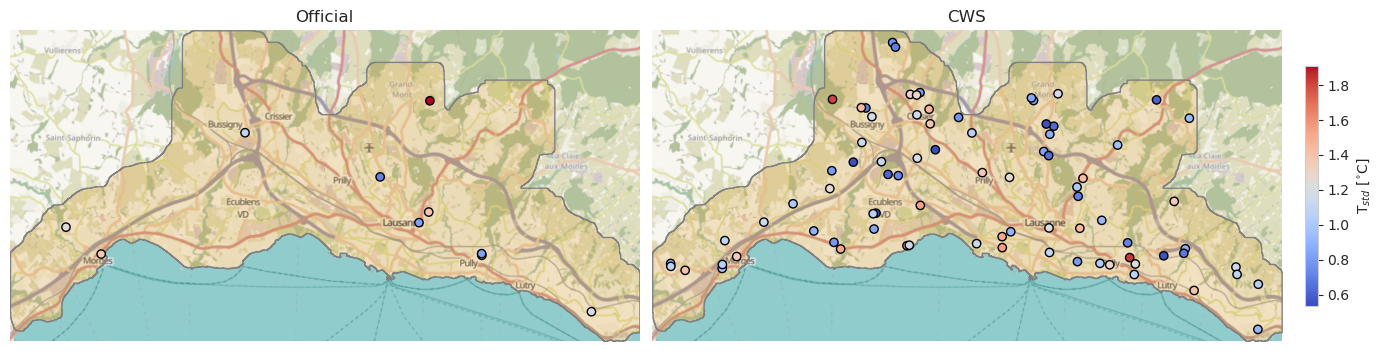

In [ ]:
fig = plot_utils.compare_maps(
    stations_gdf,
    pd.concat(
        [
            source_ts_df.apply(lambda row: row - row.mean(), axis="columns").std()
            for _, source_ts_df in ts_df_dict.items()
        ],
        axis="rows",
    ),
    var_label=t_std_label,
    region_gdf=region,
    **compare_maps_kwargs,
)

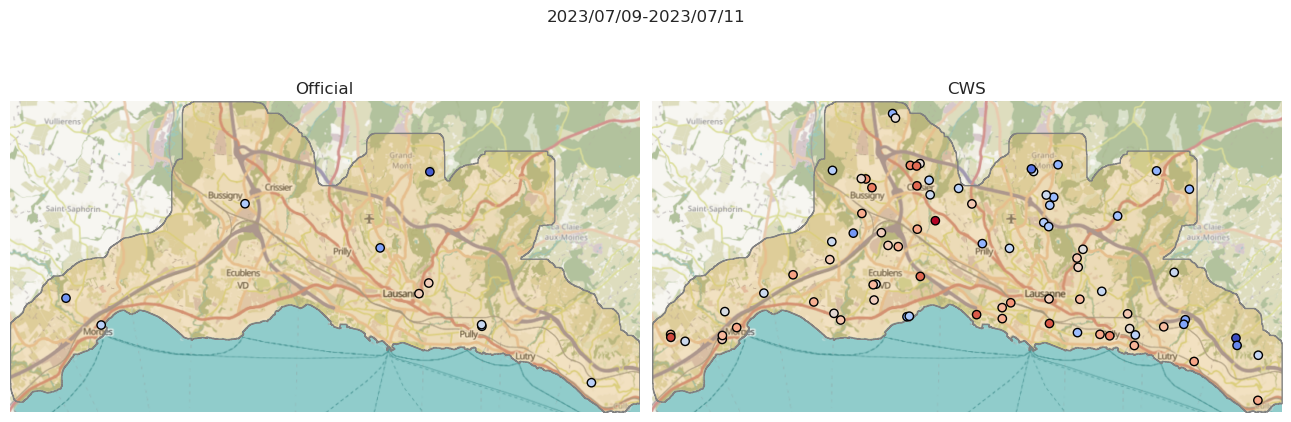

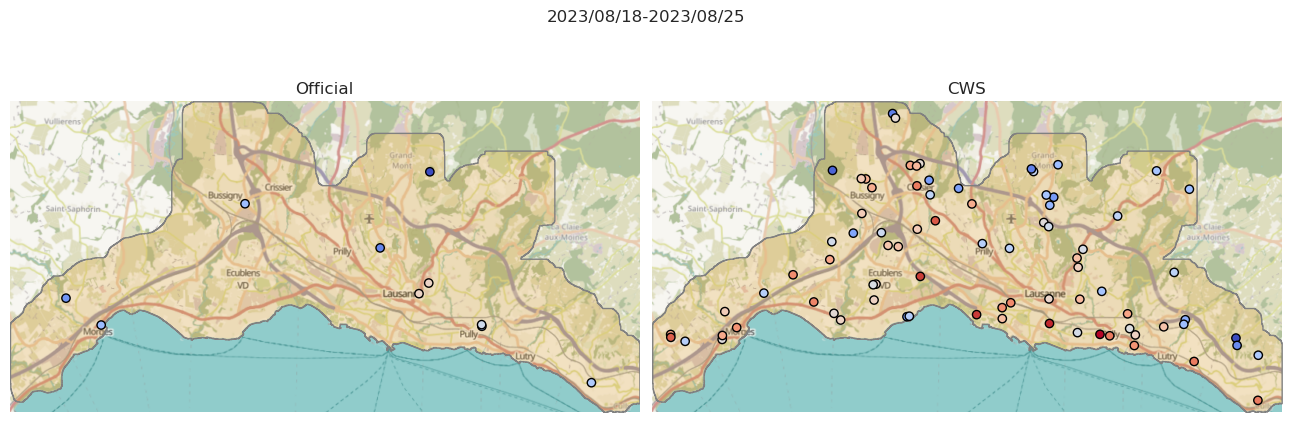

In [ ]:
for heatwave in ts_df.index.get_level_values("heatwave").unique():
    fig = plot_utils.compare_maps(
        stations_gdf,
        pd.concat(
            [
                source_ts_df.loc[heatwave]
                .apply(lambda row: row - row.min(), axis="columns")
                .mean()
                for _, source_ts_df in ts_df_dict.items()
            ],
            axis="rows",
        ),
        # var_label=uhi_mean_label,
        region_gdf=region,
        legend=False,
        **compare_maps_kwargs,
    )
    fig.suptitle(heatwave)
    # fig.savefig(
    #     f"../reports/figures/uhi-maps-{heatwave.replace('/', '-')}.png",
    #     **savefig_map_kwargs,
    # )